#Self Supervised with SimCLR

### Load SimCLR with weights

In [ ]:
pip install pytorch-lightning-bolts

     |████████████████████████████████| 253 kB 2.0 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from pl_bolts.models.self_supervised import SimCLR

# load resnet50 pretrained using SimCLR on imagenet
weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt'
simclr = SimCLR.load_from_checkpoint(weight_path, strict=False)

simclr_resnet50 = simclr.encoder
simclr_resnet50.eval()

Downloading: "https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt" to /root/.cache/torch/hub/checkpoints/simclr_imagenet.ckpt


  0%|          | 0.00/229M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

###Import libraries and define constants

In [ ]:
import torchvision.transforms as tt
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
INPUT_SIZE = 96
BATCH_SIZE = 32

### Data augmentation

In [ ]:
stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
transforms = tt.Compose([tt.RandomCrop(INPUT_SIZE, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                          tt.RandomRotation(10), 
                          tt.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
test_transforms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

### Downloading datasets and setting up data loaders

In [ ]:
ds_train = datasets.STL10(
    root="data",
    split='train',
    download=True,
    transform=transforms
)

0it [00:00, ?it/s]

Extracting data/stl10_binary.tar.gz to data


In [ ]:
ds_test = datasets.STL10(
    root="data",
    split='test',
    download=True,
    transform=test_transforms
)

Files already downloaded and verified


In [ ]:
dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
dl_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

### Defining classifier

In [ ]:
#Accuracy Function
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class Classifier (nn.Module):
    def __init__(self, in_sz=2048, classes=10):
        super().__init__()
        
        self.is_compiled = False
        
        # Dropout #1
        self.dropout_1 = nn.Dropout(0.12)
        
        # Dense #1
        self.dense_1 = nn.Linear(in_sz, 512)
        
        # Dropout #1
        self.dropout_2 = nn.Dropout(0.27)
        
        # Dense #2
        self.dense_2 = nn.Linear(512, 64) 
        
        # Dropout #3
        self.dropout_3 = nn.Dropout(0.2)

        # Out
        self.out = nn.Linear(64, classes)
        
        
    def forward(self, input):
        out = self.dropout_1(input)
        out = self.dense_1(out)
        out = self.dropout_2(out)
        out = self.dense_2(out)
        out = self.dropout_3(out)
        out = self.out(out)
        return out

    def training_step(self, batch):
        images, labels = batch
        emb = simclr_resnet50(images)
        out = self(emb[0])
        loss = self.loss_func(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        emb = simclr_resnet50(images)
        out = self(emb[0])
        loss = self.loss_func(out, labels)
        acc = self.accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    @torch.no_grad()
    def evaluate(self, val_loader):
        self.eval()
        outputs = [self.validation_step(batch) for batch in val_loader]
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def compile(self, loss_func=F.cross_entropy, accuracy=accuracy, opt_func=torch.optim.Adam):
        self.is_compiled = True
        self.loss_func = loss_func
        self.accuracy = accuracy
        self.opt_func = opt_func

    def fit(self, train_loader, test_loader, epochs, start_epoch=1, lr = 0.0004):
        if(not self.is_compiled):
            self.compile()
        history = []
        optimizer = self.opt_func(self.parameters(), lr)
        for epoch in range(start_epoch, start_epoch+epochs):
            # Training Phase 
            self.train()
            train_losses = []
            for batch in train_loader:
                loss = self.training_step(batch)
                train_losses.append(loss)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad(set_to_none = True)
   

            # Validation phase
            result = self.evaluate(test_loader)
            result['train_loss'] = torch.stack(train_losses).mean().item()

            print("Epoch [{}/{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}"
                                              .format(epoch, (start_epoch+epochs-1), result['train_loss'], result['val_loss'], result['val_acc']))

            history.append(result)
        return history
    

In [ ]:
model = Classifier()
model

Classifier(
  (dropout_1): Dropout(p=0.12, inplace=False)
  (dense_1): Linear(in_features=2048, out_features=512, bias=True)
  (dropout_2): Dropout(p=0.27, inplace=False)
  (dense_2): Linear(in_features=512, out_features=64, bias=True)
  (dropout_3): Dropout(p=0.2, inplace=False)
  (out): Linear(in_features=64, out_features=10, bias=True)
)

### Setting up GPU and shifting models and dataloaders

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
simclr_resnet50 = to_device(simclr_resnet50, device)
model = to_device(model, device)
dl_train = DeviceDataLoader(dl_train, device)
dl_test = DeviceDataLoader(dl_test, device)


### Training classifier

In [ ]:
model.compile()

In [ ]:
history = model.fit(dl_train, dl_test,8)

Epoch [1/8], train_loss: 1.0547, val_loss: 0.4904, val_acc: 0.8304
Epoch [2/8], train_loss: 0.5850, val_loss: 0.3812, val_acc: 0.8668
Epoch [3/8], train_loss: 0.5031, val_loss: 0.3710, val_acc: 0.8724
Epoch [4/8], train_loss: 0.4549, val_loss: 0.3345, val_acc: 0.8824
Epoch [5/8], train_loss: 0.4256, val_loss: 0.3378, val_acc: 0.8863
Epoch [6/8], train_loss: 0.3943, val_loss: 0.3358, val_acc: 0.8861
Epoch [7/8], train_loss: 0.3781, val_loss: 0.3355, val_acc: 0.8874
Epoch [8/8], train_loss: 0.3763, val_loss: 0.3577, val_acc: 0.8813


In [ ]:
def plot(history):
    # Accuracy plot
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    plt.show()

    # Loss plot
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    plt.show()

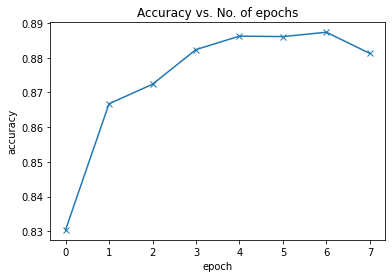

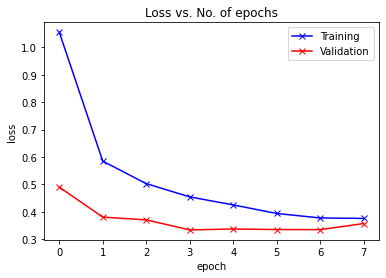

In [ ]:
plot(history)